In [1]:
import glob
import dask
import dask.dataframe as dd
import matplotlib.pyplot as plt
import time
import pandas as pd
from dask.distributed import Client
import numpy as np
import re
import datetime
from scipy import stats, interpolate, optimize
from scipy.stats import wasserstein_distance
from scipy.integrate import trapezoid as trapz_
import peakutils


/home/zahmed/.conda/envs/sams/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
# Set filtering conditions
k = ['Frame-00001', 'Frame-0001'] 
huang_rhys = [649, 720]
nv_zpl = [634.25, 640.25]
nv0_zpl = [572.0, 578]

In [3]:
# Compile regular expressions
laser_power_id = re.compile('laser_power_\\d*_')
temperature = re.compile('-?\\d*,\\d*')
acq_length = re.compile('\\d*\\.\\d*ms')
grating_center = re.compile('CWL\\d*\\.\\d*nm')
time_stamp = re.compile('202\\d \\w*\\s\\d* \\d*\\w\\d*_\\d*')
f_num = re.compile('Frame-\\d*')


# Functions to extract attributes
def extract_attributes(filename):
    lp = int(str(laser_power_id.findall(filename)).split('_')[2])
    t = float(temperature.findall(filename)[0].replace(',', '.'))
    a = float(acq_length.findall(filename)[0].replace('ms', ''))
    b = float(grating_center.findall(filename)[0].strip('CWL').strip('nm'))
    
    g = time_stamp.findall(filename)[0].split(' ')
    year, month_str, day, hr = g[0], g[1], g[2], g[3]
    h, m, s = hr.split('_')
    month = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 
              'May': 5, 'June': 6, 'July': 7, 'August': 8, 
              'September': 9, 'October': 10, 'November': 11, 'December': 12}[month_str]
    
    mt = time.mktime(datetime.datetime(int(year), month, int(day), int(h), int(m), int(s)).timetuple())
    fnm = int(f_num.findall(filename)[0].split('-')[1])
    
    return mt, lp, t, a, b, fnm

# File filtering function
def filter_files(file_list):
    filtered_files = sorted([f for f in file_list if all(kw not in f for kw in k)], key=lambda x: extract_attributes(x)[0])
    return filtered_files 

In [4]:

# File path
fpath = '../data/sensor2_week5_cycling/*.csv'
files = filter_files(glob.glob(fpath))

In [5]:
len(files)

419538

In [6]:
# Load reference spectrum and normalize
df0 = pd.read_csv(files[1], sep=',')
spectrum1 = df0['Intensity'] / np.sum(df0['Intensity'])

In [7]:
# KL Divergence function
def kl_divergence(spectrum, spectrum1):
    spectrum = spectrum / np.sum(spectrum)
    return np.sum(np.log(spectrum1 / spectrum) * spectrum1)

# Gaussian function for fitting
def gaussian(x, amp, u, std):
    return amp * np.exp(-((x - u) ** 2 / (2 * std ** 2)))

def lorentzian(x_zpl, x0, a, gam ):
    '''fits a Lorentzian to the curve   '''
    return a * gam**2 / ( gam**2 + ( x_zpl - x0 )**2)

In [8]:
# Process a single file and extract features
def process_file(file_path, nv_type='nv', fit_params=[4000, 637.5, 1.5], func = 'gaussian' ,max_fev=50000):
    if nv_type == 'nv':
        zp = nv_zpl
    else:
        zp = nv0_zpl

    df = pd.read_csv(file_path, sep=',')
    df.sort_values(by='Wavelength', inplace=True)
    df.drop_duplicates(subset='Wavelength', inplace=True)
    
    x, y = df['Wavelength'].values, df['Intensity'].values
    x_zpl_range = (np.abs(x - zp[0])).argmin(), (np.abs(x - zp[1])).argmin()
    x_zpl, y_zpl = x[x_zpl_range[0]:x_zpl_range[1]], y[x_zpl_range[0]:x_zpl_range[1]]
    
    base = peakutils.baseline(y_zpl, 1)
    y_zpl_base = y_zpl - base
    dx_val = (x[0] - x[10]) / 10
    
    area_zpl = trapz_(y[x_zpl_range[0]:x_zpl_range[1]], dx=dx_val)
    area_psb = trapz_(y[(np.abs(x - huang_rhys[0])).argmin():(np.abs(x - huang_rhys[1])).argmin()], dx=dx_val)
    dw = area_zpl / area_psb
    
    if func == 'gaussian':
        popt, _ = optimize.curve_fit(gaussian, x_zpl, y_zpl_base, p0=fit_params, maxfev=max_fev)
        amp, center_wavelength, FWHM = popt
        
    else:
        popt, _ = optimize.curve_fit(lorentzian, x_zpl, y_zpl_base, p0=fit_params, maxfev=max_fev)
        amp, center_wavelength, FWHM = popt
    

    return {
        'debye_waller': dw,
        'amplitude': amp,
        'peak_center': center_wavelength,
        'width': FWHM,
        'time': extract_attributes(file_path)[0],
        'laser_power': extract_attributes(file_path)[1],
        'temperature': extract_attributes(file_path)[2],
        'kld_divergence': kl_divergence(y, spectrum1),
        'wasserstein': wasserstein_distance(y, spectrum1),
        'sensor' : 'sensor_2',
        'frame_num': extract_attributes(file_path)[5]

    }


In [9]:
# Initialize Dask client
client = Client(n_workers=10, threads_per_worker=1, memory_limit='15GB')

# Create and compute delayed tasks
start_time = time.time()
delayed_results = [dask.delayed(process_file)(f) for f in files]
#delayed_results = [dask.delayed(process_file)(f, func='lorentzian') for f in files[:1000]]

results = dask.compute(*delayed_results)

client.close()
print(f"Processing time: {time.time() - start_time:.2f} seconds")

/home/zahmed/.conda/envs/sams/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41239 instead
  warnings.warn(
/home/zahmed/.conda/envs/sams/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 92.97 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Processing time: 1817.29 seconds


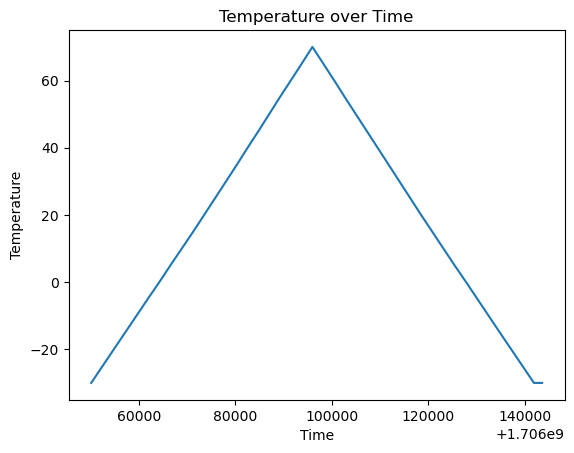

In [10]:
# Convert results to DataFrame
df2 = pd.DataFrame(results)

# Plotting results
plt.plot(df2['time'].values, df2['temperature'].values)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature over Time')
plt.show()

In [11]:
df2.head()

,debye_waller,amplitude,peak_center,width,time,laser_power,temperature,kld_divergence,wasserstein,sensor,frame_num
0,0.016335,1723.353586,637.300584,1.064420,1.706050e+09,10,-30.0,0.000101,14007.927612,sensor_2,6754
1,0.016422,1758.758263,637.256696,1.083939,1.706050e+09,10,-30.0,0.000000,14003.404478,sensor_2,6512
2,0.016339,1737.796638,637.287588,1.082704,1.706050e+09,10,-30.0,0.000102,13984.134328,sensor_2,8708
3,0.016302,1754.187654,637.271195,1.076798,1.706050e+09,10,-30.0,0.000102,14000.227612,sensor_2,8291
4,0.016315,1770.041640,637.292338,1.080657,1.706050e+09,10,-30.0,0.000105,14003.462687,sensor_2,8474


In [12]:
df2.count()

debye_waller      419538
amplitude         419538
peak_center       419538
width             419538
time              419538
laser_power       419538
temperature       419538
kld_divergence    419538
wasserstein       419538
sensor            419538
frame_num         419538
dtype: int64

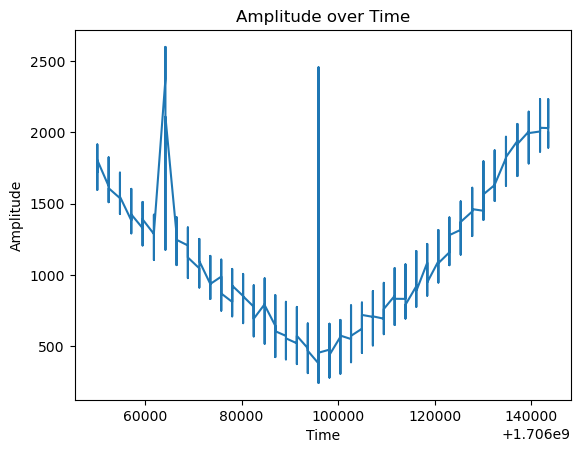

In [13]:
# Plotting results
plt.plot(df2['time'].values, df2['amplitude'].values)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Amplitude over Time')
plt.show()

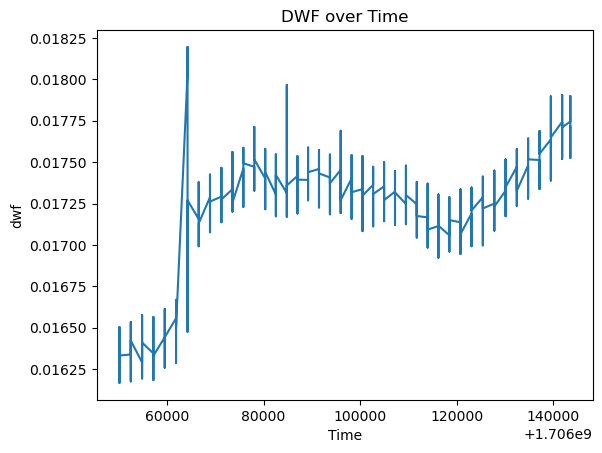

In [14]:
# Plotting results
plt.plot(df2['time'].values, df2['debye_waller'].values)
plt.xlabel('Time')
plt.ylabel('dwf')
plt.title('DWF over Time')
plt.show()

In [15]:
export_name = 'sensor2_fifth_cycle_week_5_DWF_649_720_nm'
df2.to_csv('../saved_data/'+export_name)

In [16]:
print(f"Processing time: {time.time() - start_time:.2f} seconds")

Processing time: 1824.15 seconds


In [17]:
client.close()